<a href="https://colab.research.google.com/github/regain001/Machine-Learning/blob/master/Paper%20Review%20Analysis/Paper-Review-Analysis_(Binary-Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification (label : Orientation)

### **`Applied Hyper parameter tuning with k-Fold Cross-Validation in 4 different types of classifier algorithms`**
*SVM, Random Forest, Multinomial Naive Bayes, Logistic Regression*

*Using Count Vectorizer Technic*


**`Label : Orientation`**


#### **Data Preprocessing**

In [0]:
import json

!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


In [0]:
data=[]
for item in dataStore['paper']:

  primary_decision = item['preliminary_decision']
  item_reviews = item['review']

  for item in item_reviews:
    ls = []
    # orientation = item['orientation']
    evaluation = item['evaluation']
    confidence = item['confidence']
    remarks = item['remarks']
    text = item['text']

    label = item['orientation']

    if(label == '1' or label == '2') : label = 1
    # elif( label == '0'): label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):
      ls.append(int(label))
      ls.append(int(evaluation))
      ls.append(int(confidence or 0))
      # ls.append(primary_decision)
      ls.append(text)

    # if(text!=""):ls.append("text")
    # else: ls.append("no text")

    # if(remarks!=""):ls.append("remarks")
    # else: ls.append("no remarks")

      data.append(ls)

print(len(data))

import pandas as pd
data = pd.DataFrame(data, columns=['orientation', 'evaluation', 'confidence', 'texts'])
# data.hist(figsize=(10,10), bins = 15)
# data.hist(column='orientation', bins = 15)
# print(len(labels))
# dt =  pd.DataFrame(labels, columns=['Ternary Classification : Orientation'])
# dt.hist()
data[5:8]

382


,orientation,evaluation,confidence,texts
5,1,2,4,Este trabajo propone un nuevo enfoque basado e...
6,1,2,4,Se realiza un trabajo de modelamiento de encri...
7,0,-2,2,Este paper involucra el desarrollo de una apli...


In [0]:
target = data.orientation
inputs = data
# inputs = data.drop(['confidence'], axis = 'columns')
# data.head()
# inputs.head()

In [0]:
# One hot encoding
# dummies = pd.get_dummies(inputs.decision)
# dummies.head(2)

In [0]:
# inputs = pd.concat([inputs,dummies],axis='columns')
# inputs.head(3)

In [0]:
inputs.columns[inputs.isna().any()]
data.groupby('orientation').describe()

evaluation                                ... confidence                    
                 count      mean       std  min  25%  ...        min  25%  50%  75%  max
orientation                                           ...                               
0                276.0 -0.438406  1.359081 -2.0 -2.0  ...        0.0  3.0  4.0  4.0  5.0
1                106.0  1.622642  0.576572  0.0  1.0  ...        1.0  3.0  3.0  4.0  5.0

[2 rows x 16 columns]

#### **Applying different Classifier Algorithms**

In [0]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    }

    # 'naive_bayes_gaussian': {
    #     'model': GaussianNB(),
    #     'params': {}
    # },
    # 'decision_tree': {
    #     'model': DecisionTreeClassifier(),
    #     'params': {
    #         'criterion': ['gini','entropy'],
    #     }
    # }  
}

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, f1_score, auc
from sklearn.model_selection import GridSearchCV, train_test_split
scores = []
X_train, X_test, y_train, y_test = train_test_split(inputs.texts,target, test_size = .25)

v = CountVectorizer()
X_train_count = v.fit_transform(X_train.values)
X_test_count = v.transform(X_test.values)
X_test_count = v.transform(X_test)


for model_name, mp in model_params.items():
    
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_count, y_train)
    clf.score(X_test_count, y_test)

    y_predicted = clf.predict(X_test_count)
    conf_matx = confusion_matrix(y_test, y_predicted)

    # define pos label in order to calculate precision, recall, F1-Score, ROC 
    # for a ##specific Class
    positive_lbl = 1
    fpr, tpr, _ = roc_curve(y_test, y_predicted, pos_label = positive_lbl)
    roc_auc = auc(fpr, tpr)

    precision = precision_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    recall = recall_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    f1_scor = f1_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'c_matrix': conf_matx ,
        'roc_auc' : roc_auc,
        'precision' : precision,
        'recall' : recall,
        'f1_score' : f1_scor,
        'tpr' : tpr,
        'fpr' : fpr
    })
    

df = pd.DataFrame(scores,columns=['model','best_score','best_params', 'c_matrix', 'roc_auc', 
                                  'precision', 'recall', 'f1_score', 'tpr', 'fpr'])

df[['model','best_score','best_params']]

,model,best_score,best_params
0,svm,0.793466,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.744767,{'n_estimators': 10}
2,logistic_regression,0.804053,{'C': 10}
3,naive_bayes_multinomial,0.744828,{}


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

c_matx = df['c_matrix']
roc_auc = df['roc_auc']
tpr =  df['tpr']
fpr = df['fpr']

def plot_roc(roc_index, title):
  plt.figure()
  lw = 2
  plt.plot(fpr[roc_index], tpr[roc_index], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[roc_index])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC : '+title)
  plt.legend(loc="lower right")
  plt.show()


def plot_cmatricx(c_matx_index, title):
  plt.figure(figsize = (5,4))
  sn.heatmap(c_matx[c_matx_index], annot=True)
  plt.title('Confusion Matricx : '+ title)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')

def otherValues(index):
  print('Accuracy :', df['best_score'][index])
  print('Precision :', df['precision'][index])
  print('Recall :', df['recall'][index])
  print('F1-Score :', df['f1_score'][index])

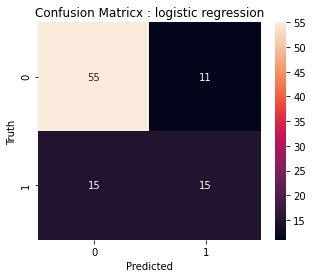

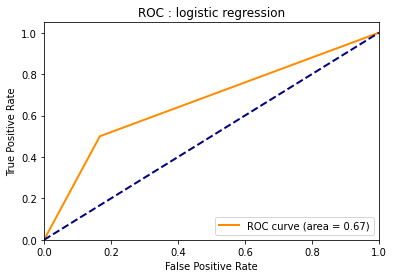

Accuracy : 0.8040532365396251
Precision : 0.6813186813186813
Recall : 0.6666666666666667
F1-Score : 0.6722689075630253


In [0]:
title = 'logistic regression'
index = 2
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

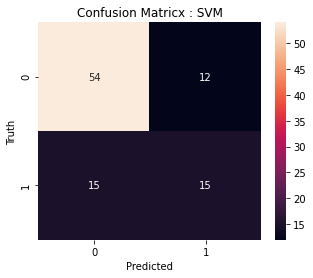

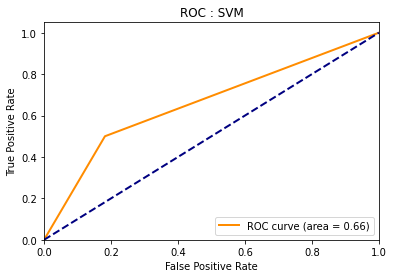

Accuracy : 0.7934664246823957
Precision : 0.6690821256038648
Recall : 0.6590909090909092
F1-Score : 0.6631578947368422


In [0]:
title = 'SVM'
index = 0
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

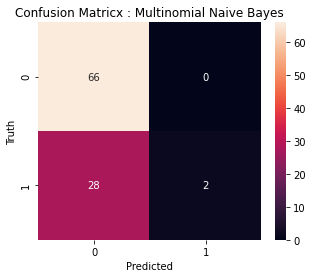

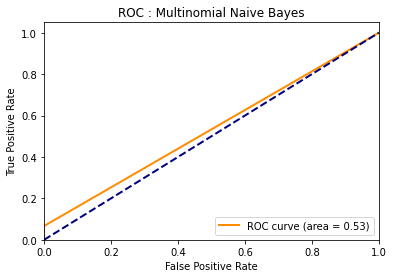

Accuracy : 0.7448275862068966
Precision : 0.851063829787234
Recall : 0.5333333333333333
F1-Score : 0.475


In [0]:
title = 'Multinomial Naive Bayes'
index = 3
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

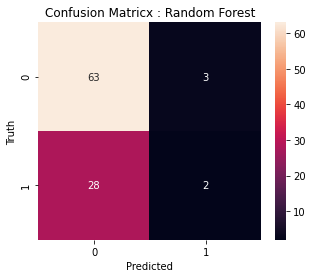

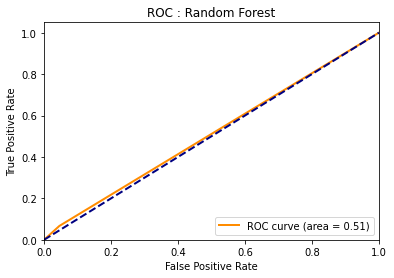

Accuracy : 0.744767090139141
Precision : 0.5461538461538462
Recall : 0.5106060606060606
F1-Score : 0.4584167424931756


In [0]:
title = 'Random Forest'
index = 1
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

In [0]:
dir(clf)

### Sentiment Analysis using **Word Embedding**

In [0]:
import json
import tensorflow as tf
import tensorflow_addons as tfa
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# Define Hyper parameter
vocab_size = 25000
embedding_dim = 16 # 16 dimentions
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3

In [0]:
!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []

with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)

--2020-05-09 10:23:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593600 (580K) [application/x-httpd-php]
Saving to: ‘/tmp/reviews.json’

/tmp/reviews.json   100%[===================>] 579.69K  1.81MB/s    in 0.3s    

2020-05-09 10:23:34 (1.81 MB/s) - ‘/tmp/reviews.json’ saved [593600/593600]



In [0]:
texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" & remove stop words
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text']
    label = item['orientation']
    if( label == '1' or label == '2') : label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):
      texts.append(text)
      labels.append(label)

print(len(texts)) 

382


In [0]:
ones = 0
zeros = 0

for i in labels:
  if (i == 0) : zeros+=1
  if i == 1 : ones+=1

print("label 1's :",ones) 
print("label 0's :",zeros) 

label 1's : 106
label 0's : 276


In [0]:
random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index


# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


training size :  267
testing size :  115


In [0]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'), # 6 nurons
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 nurons 
])
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 16)           400000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 400,433
Trainable params: 400,433
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels), verbose = 2)

Epoch 1/10
9/9 - 1s - loss: 0.6889 - accuracy: 0.7154 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_curve: 0.4465 - FP: 0.0000e+00 - FN: 76.0000 - TP: 0.0000e+00 - TN: 191.0000 - f1_score: 0.4431 - val_loss: 0.6816 - val_accuracy: 0.7391 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_curve: 0.5255 - val_FP: 0.0000e+00 - val_FN: 30.0000 - val_TP: 0.0000e+00 - val_TN: 85.0000 - val_f1_score: 0.4138
Epoch 2/10
9/9 - 0s - loss: 0.6790 - accuracy: 0.7154 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_curve: 0.4738 - FP: 0.0000e+00 - FN: 76.0000 - TP: 0.0000e+00 - TN: 191.0000 - f1_score: 0.4431 - val_loss: 0.6706 - val_accuracy: 0.7391 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_curve: 0.5490 - val_FP: 0.0000e+00 - val_FN: 30.0000 - val_TP: 0.0000e+00 - val_TN: 85.0000 - val_f1_score: 0.4138
Epoch 3/10
9/9 - 0s - loss: 0.6689 - accuracy: 0.7154 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_curve: 0.4788 - FP: 0.0000e+00 - FN: 76.0000 - TP: 0.

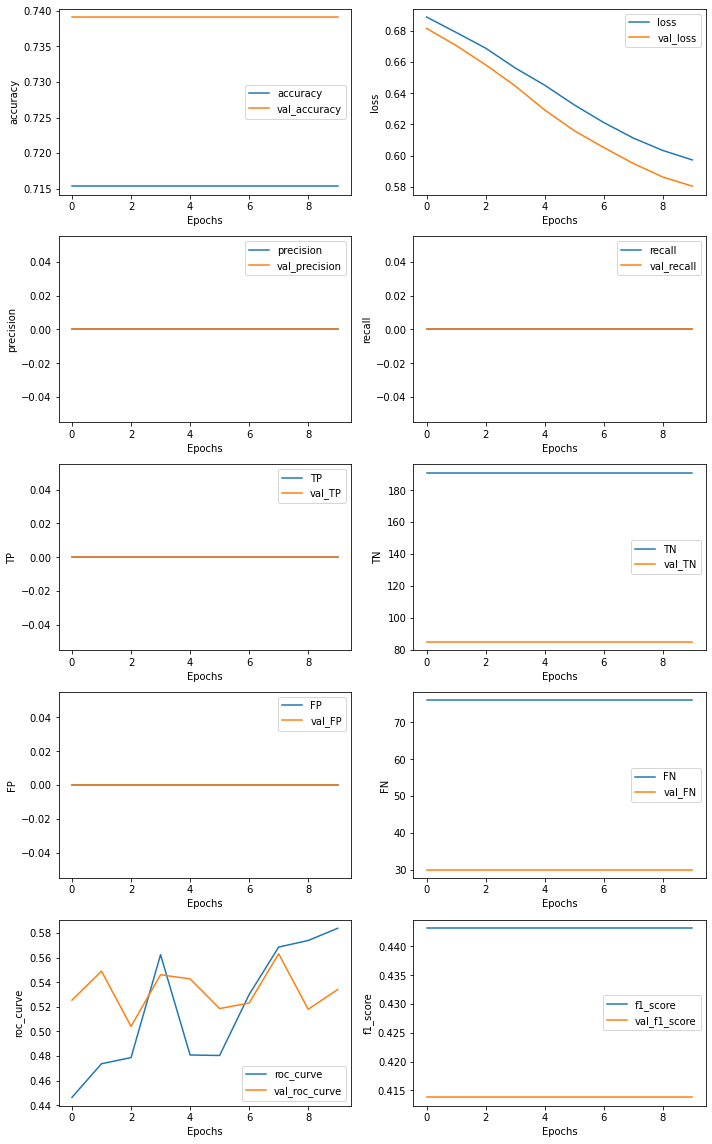

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)
fig.tight_layout()


4/4 - 0s - loss: 0.5805 - accuracy: 0.7391 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_curve: 0.5341 - FP: 0.0000e+00 - FN: 30.0000 - TP: 0.0000e+00 - TN: 85.0000 - f1_score: 0.4138
Test loss: 0.5804843306541443
Test accuracy: 0.739130437374115


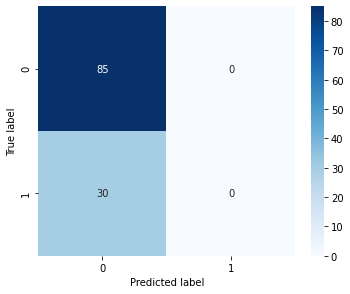

[[85  0]
 [30  0]]


In [0]:
y_pred = model.predict_classes(testing_padded)
confusion_matrix = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()

test_scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

figure = plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(confusion_matrix)

### Using Previous model with removing **stopwords**

In [0]:
import json
import tensorflow as tf
import tensorflow_addons as tfa
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Hyper parameter
vocab_size = 25000
embedding_dim = 32 # 16 dimentions
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" & remove stop words
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text']
    label = item['orientation']

    if( label == '1' or label == '2') : label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):

      for word in stopwords:
        token = " " + word + " " ; 
        text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)

print(len(texts))
print(len(texts)) 


random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index


# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'), # 6 nurons
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 nurons 
])

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels), verbose = 2)

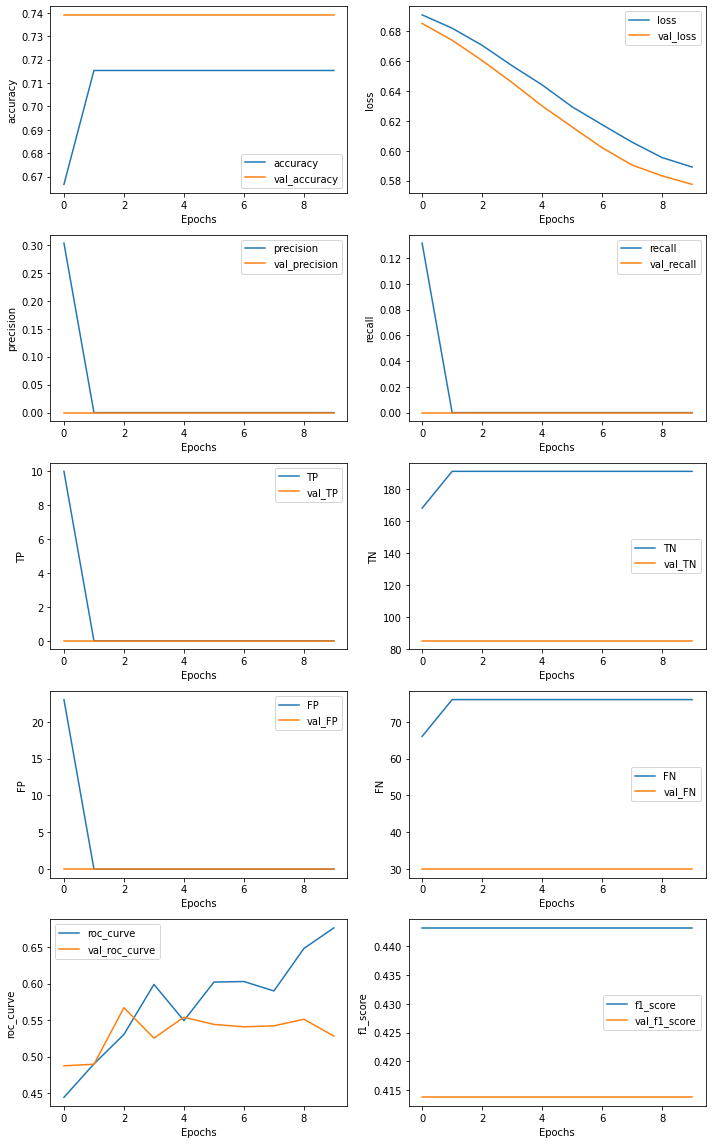

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)

fig.tight_layout()


4/4 - 0s - loss: 0.5775 - accuracy: 0.7391 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_curve: 0.5280 - FP: 0.0000e+00 - FN: 30.0000 - TP: 0.0000e+00 - TN: 85.0000 - f1_score: 0.4138
Test loss: 0.5775133371353149
Test accuracy: 0.739130437374115


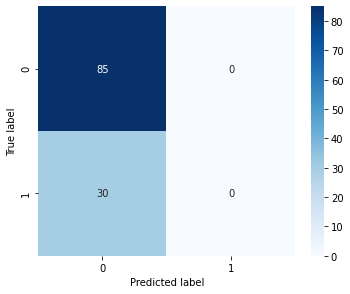

[[85  0]
 [30  0]]


In [0]:
y_pred = model.predict_classes(testing_padded)
confusion_matrix = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()

test_scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

# import pandas as pd
# classes = [0,1]
# confusion_matrix_norm = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

# confusion_matrix_df = pd.DataFrame(confusion_matrix_norm,
#                      index = classes, 
#                      columns = classes)

figure = plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(confusion_matrix)

### Analyze using Global Vector(**GloVe**) & **LSTM**

In [0]:
import json
import tensorflow as tf
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Hyper parameter
# vocab_size = 25000
embedding_dim = 100 # 16 dimentions
max_length = 1000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" 
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text']
    label = item['orientation']

    if( label == '1' or label == '2') : label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):

      # for word in stopwords:
      #   token = " " + word + " " ; 
      #   text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)

print(len(texts))
print(len(texts)) 

random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(word_index)

# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [0]:
# Note this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [0]:
import tensorflow_addons as tfa

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 100)         561300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 16)           8016      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 16)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 571,445
Trainable params: 10,145
Non-trainable params: 561,300
_________________________________________________________________
Epoch 1/10
9/9 - 2s - loss: 0.6881 - accuracy: 0.7116 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_curv

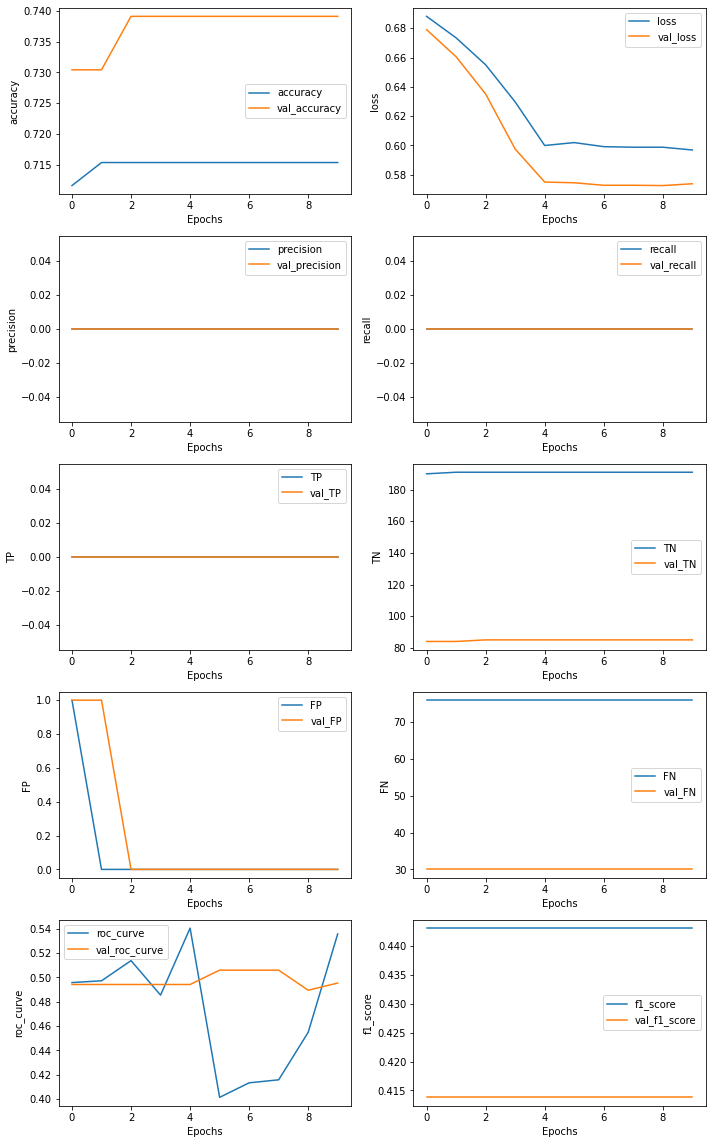

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)

fig.tight_layout()


4/4 - 0s - loss: 0.5738 - accuracy: 0.7391 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_curve: 0.4953 - FP: 0.0000e+00 - FN: 30.0000 - TP: 0.0000e+00 - TN: 85.0000 - f1_score: 0.4138
Test loss: 0.573828399181366
Test accuracy: 0.739130437374115


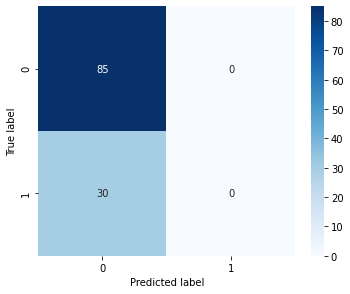

[[85  0]
 [30  0]]


In [0]:
y_pred = model.predict_classes(testing_padded)
confusion_matrix = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()

test_scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

figure = plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(confusion_matrix)

# Binary Classification (label : Evaluation)

### **`Applied Hyper parameter tuning with k-Fold Cross-Validation in 4 different types of classifier algorithms`**
*SVM, Random Forest, Multinomial Naive Bayes, Logistic Regression*

*Using Count Vectorizer Technic*

**`Label : Evaluation`**


#### **Data Preprocessing**

In [0]:
import json

!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


382


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdbd88e5c0>]],
      dtype=object)

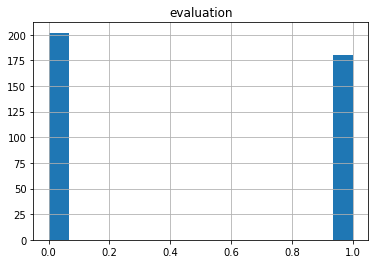

In [0]:
data=[]
for item in dataStore['paper']:

  primary_decision = item['preliminary_decision']
  item_reviews = item['review']

  for item in item_reviews:
    ls = []
    orientation = item['orientation']
    # evaluation = item['evaluation']
    confidence = item['confidence']
    remarks = item['remarks']
    text = item['text']

    label = item['evaluation']

    if(label == '1' or label == '2') : label = 1
    # elif( label == '0'): label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):
      ls.append(int(label))
      ls.append(int(orientation))
      ls.append(int(confidence or 0))
      # ls.append(primary_decision)
      ls.append(text)

    # if(text!=""):ls.append("text")
    # else: ls.append("no text")

    # if(remarks!=""):ls.append("remarks")
    # else: ls.append("no remarks")

      data.append(ls)

print(len(data))

import pandas as pd
data = pd.DataFrame(data, columns=['evaluation', 'orientation', 'confidence', 'texts'])
# data.hist(figsize=(10,10), bins = 15)
# data.hist(column='orientation', bins = 15)
# print(len(labels))
# dt =  pd.DataFrame(labels, columns=['Ternary Classification : Orientation'])
# dt.hist()
data[5:8]
data.hist(column='evaluation', bins = 15)

In [0]:
target = data.evaluation
inputs = data
# inputs = data.drop(['confidence'], axis = 'columns')
# data.head()
# inputs.head()

In [0]:
# One hot encoding
# dummies = pd.get_dummies(inputs.decision)
# dummies.head(2)

In [0]:
# inputs = pd.concat([inputs,dummies],axis='columns')
# inputs.head(3)

In [0]:
inputs.columns[inputs.isna().any()]
data.groupby('evaluation').describe()

orientation                                ... confidence                    
                 count      mean       std  min  25%  ...        min  25%  50%  75%  max
evaluation                                            ...                               
0                202.0 -0.925743  0.683444 -2.0 -1.0  ...        0.0  3.0  4.0  4.0  5.0
1                180.0  0.561111  0.763437 -1.0  0.0  ...        1.0  3.0  4.0  4.0  5.0

[2 rows x 16 columns]

#### **Applying different Classifier Algorithms**

In [0]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    }

    # 'naive_bayes_gaussian': {
    #     'model': GaussianNB(),
    #     'params': {}
    # },
    # 'decision_tree': {
    #     'model': DecisionTreeClassifier(),
    #     'params': {
    #         'criterion': ['gini','entropy'],
    #     }
    # }  
}

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, f1_score, auc
from sklearn.model_selection import GridSearchCV, train_test_split

scores = []
X_train, X_test, y_train, y_test = train_test_split(inputs.texts,target, test_size = .25)

v = CountVectorizer()
X_train_count = v.fit_transform(X_train.values)
X_test_count = v.transform(X_test.values)
X_test_count = v.transform(X_test)


for model_name, mp in model_params.items():
    
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_count, y_train)
    clf.score(X_test_count, y_test)

    y_predicted = clf.predict(X_test_count)
    conf_matx = confusion_matrix(y_test, y_predicted)

    # define pos label in order to calculate precision, recall, F1-Score, ROC 
    # for a ##specific Class
    positive_lbl = 1
    fpr, tpr, _ = roc_curve(y_test, y_predicted, pos_label = positive_lbl)
    roc_auc = auc(fpr, tpr)

    precision = precision_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    recall = recall_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    f1_scor = f1_score(y_true=y_test, y_pred=y_predicted, average='macro', pos_label = positive_lbl)
    
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'c_matrix': conf_matx ,
        'roc_auc' : roc_auc,
        'precision' : precision,
        'recall' : recall,
        'f1_score' : f1_scor,
        'tpr' : tpr,
        'fpr' : fpr
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params', 'c_matrix', 'roc_auc', 
                                  'precision', 'recall', 'f1_score', 'tpr', 'fpr'])
df[['model','best_score','best_params', 'f1_score']]

,model,best_score,best_params,f1_score
0,svm,0.709679,"{'C': 20, 'kernel': 'rbf'}",0.669002
1,random_forest,0.660920,{'n_estimators': 10},0.669002
2,logistic_regression,0.692317,{'C': 5},0.666087
3,naive_bayes_multinomial,0.608711,{},0.581478


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

c_matx = df['c_matrix']
roc_auc = df['roc_auc']
tpr =  df['tpr']
fpr = df['fpr']

def plot_roc(roc_index, title):
  plt.figure()
  lw = 2
  plt.plot(fpr[roc_index], tpr[roc_index], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[roc_index])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC : '+title)
  plt.legend(loc="lower right")
  plt.show()


def plot_cmatricx(c_matx_index, title):
  plt.figure(figsize = (5,4))
  sn.heatmap(c_matx[c_matx_index], annot=True)
  plt.title('Confusion Matricx : '+ title)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')

def otherValues(index):
  print('Accuracy :', df['best_score'][index])
  print('Precision :', df['precision'][index])
  print('Recall :', df['recall'][index])
  print('F1-Score :', df['f1_score'][index])

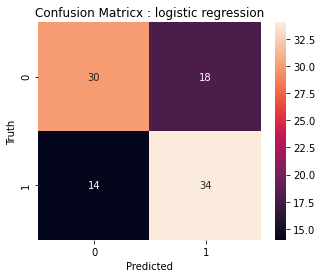

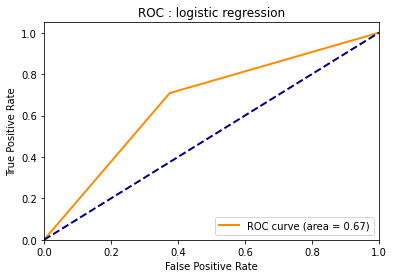

Accuracy : 0.6923169993950393
Precision : 0.6678321678321678
Recall : 0.6666666666666667
F1-Score : 0.6660869565217391


In [0]:
title = 'logistic regression'
index = 2
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

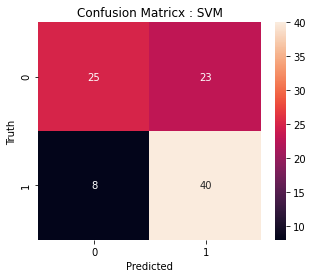

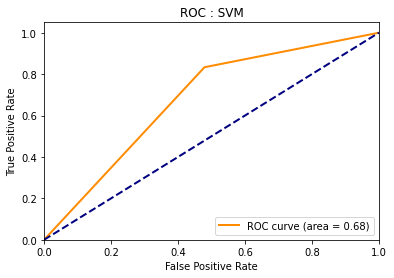

Accuracy : 0.7096793708408955
Precision : 0.6962481962481962
Recall : 0.6770833333333334
F1-Score : 0.6690023356690022


In [0]:
title = 'SVM'
index = 0
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

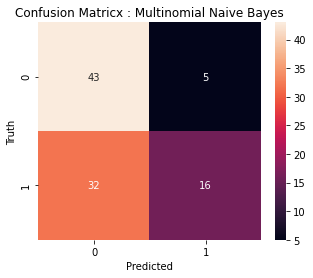

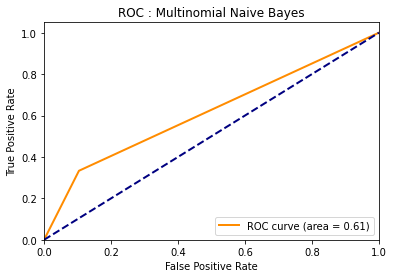

Accuracy : 0.6087114337568058
Precision : 0.6676190476190476
Recall : 0.6145833333333334
F1-Score : 0.5814775539059739


In [0]:
title = 'Multinomial Naive Bayes'
index = 3
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

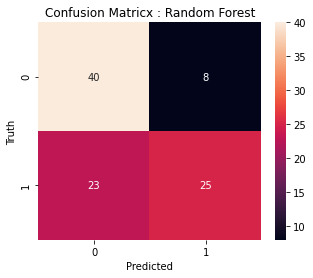

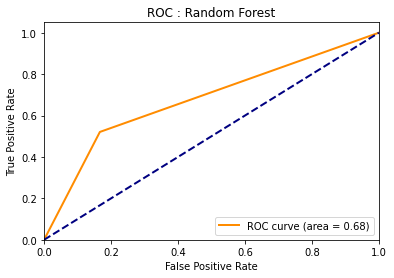

Accuracy : 0.660919540229885
Precision : 0.6962481962481962
Recall : 0.6770833333333334
F1-Score : 0.6690023356690022


In [0]:
title = 'Random Forest'
index = 1
plot_cmatricx(index, title)
plot_roc(index, title)
otherValues(index)

In [0]:
dir(clf)

### Sentiment Analysis using **Word Embedding**

In [0]:
import json
import tensorflow as tf
import tensorflow_addons as tfa
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# Define Hyper parameter
vocab_size = 25000
embedding_dim = 16 # 16 dimentions
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3

In [0]:
!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []

with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)

In [0]:
texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" 
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text']
    label = item['evaluation']
    if( label == '0'or label == '1' or label == '2') : label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):
      texts.append(text)
      labels.append(label)

print(len(texts)) 

382


In [0]:
ones = 0
zeros = 0

for i in labels:
  if (i == 0) : zeros+=1
  if i == 1 : ones+=1

print("label 1's :",ones) 
print("label 0's :",zeros) 

label 1's : 239
label 0's : 143


In [0]:
random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index


# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


training size :  267
testing size :  115


In [0]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'), # 6 nurons
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 nurons 
])
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 16)           400000    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 25        
Total params: 400,433
Trainable params: 400,433
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels), verbose = 2)

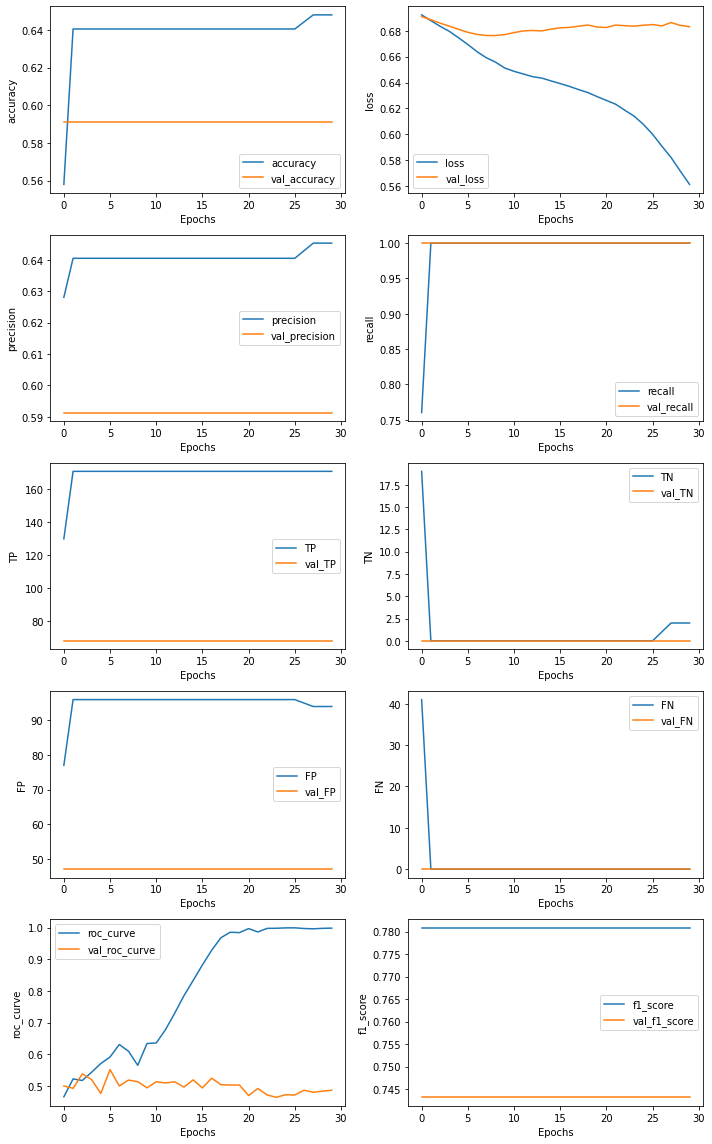

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)
fig.tight_layout()


4/4 - 0s - loss: 0.6831 - accuracy: 0.5913 - precision: 0.5913 - recall: 1.0000 - roc_curve: 0.4865 - FP: 47.0000 - FN: 0.0000e+00 - TP: 68.0000 - TN: 0.0000e+00 - f1_score: 0.7432
Test loss: 0.683134138584137
Test accuracy: 0.591304361820221


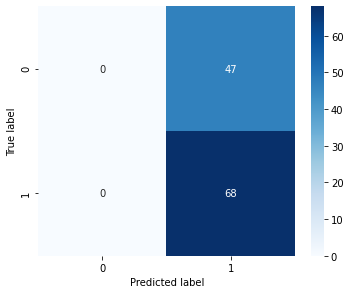

[[ 0 47]
 [ 0 68]]


In [0]:
y_pred = model.predict_classes(testing_padded)
confusion_matrix = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()

test_scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

figure = plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(confusion_matrix)

### Using Previous model with removing **stopwords**

In [0]:
import json
import tensorflow as tf
import tensorflow_addons as tfa
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Hyper parameter
vocab_size = 25000
embedding_dim = 32 # 16 dimentions
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" & remove stop words
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text']
    label = item['evaluation']
    if( label == '0'or label == '1' or label == '2') : label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):

      for word in stopwords:
        token = " " + word + " " ; 
        text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)

print(len(texts))
print(len(texts)) 


random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index


# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'), # 6 nurons
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 nurons 
])

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels), verbose = 2)

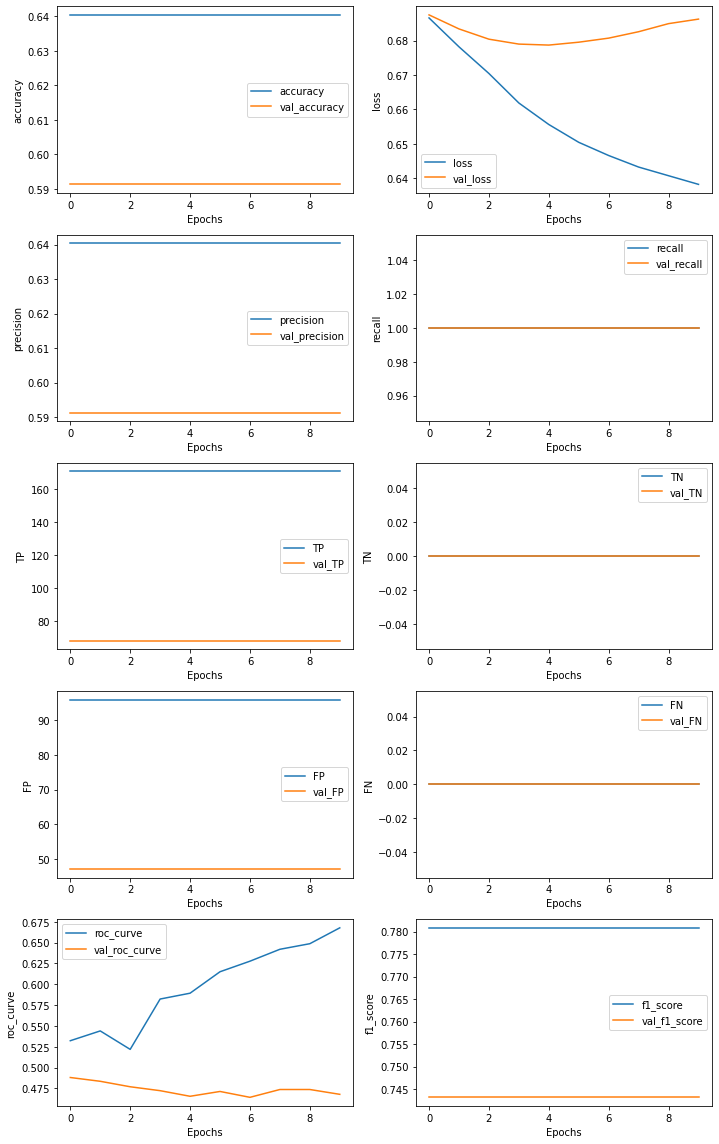

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)

fig.tight_layout()


4/4 - 0s - loss: 0.6863 - accuracy: 0.5913 - precision: 0.5913 - recall: 1.0000 - roc_curve: 0.4679 - FP: 47.0000 - FN: 0.0000e+00 - TP: 68.0000 - TN: 0.0000e+00 - f1_score: 0.7432
Test loss: 0.6862567663192749
Test accuracy: 0.591304361820221


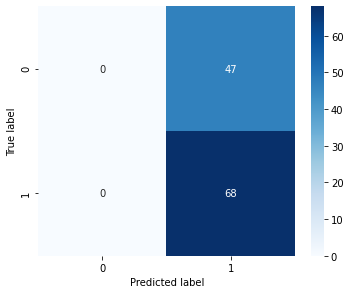

[[ 0 47]
 [ 0 68]]


In [0]:
y_pred = model.predict_classes(testing_padded)
confusion_matrix = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()

test_scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

figure = plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(confusion_matrix)

### Analyze using Global Vector(**GloVe**) & **LSTM**

In [0]:
import json
import tensorflow as tf
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Hyper parameter
# vocab_size = 25000
embedding_dim = 100 # 16 dimentions
max_length = 1000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" 
for item in dataStore['paper']:
  item_reviews = item['review']
  for item in item_reviews:
    text = item['text']
    label = item['evaluation']
    
    if( label == '0'or label == '1' or label == '2') : label = 1
    else : label = 0

    if(item['text']!="" and item['lan']!="en"):

      # for word in stopwords:
      #   token = " " + word + " " ; 
      #   text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)

print(len(texts))
print(len(texts)) 

random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(word_index)

# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [0]:
# Note this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [0]:
import tensorflow_addons as tfa

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1000, 100)         531000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 16)           8016      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 249, 16)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 541,145
Trainable params: 10,145
Non-trainable params: 531,000
_________________________________________________________________
Epoch 1/10
9/9 - 2s - loss: 0.6893 - accuracy: 0.5993 - precision: 0.6356 - recall: 0.8772 - roc_curve: 0.55

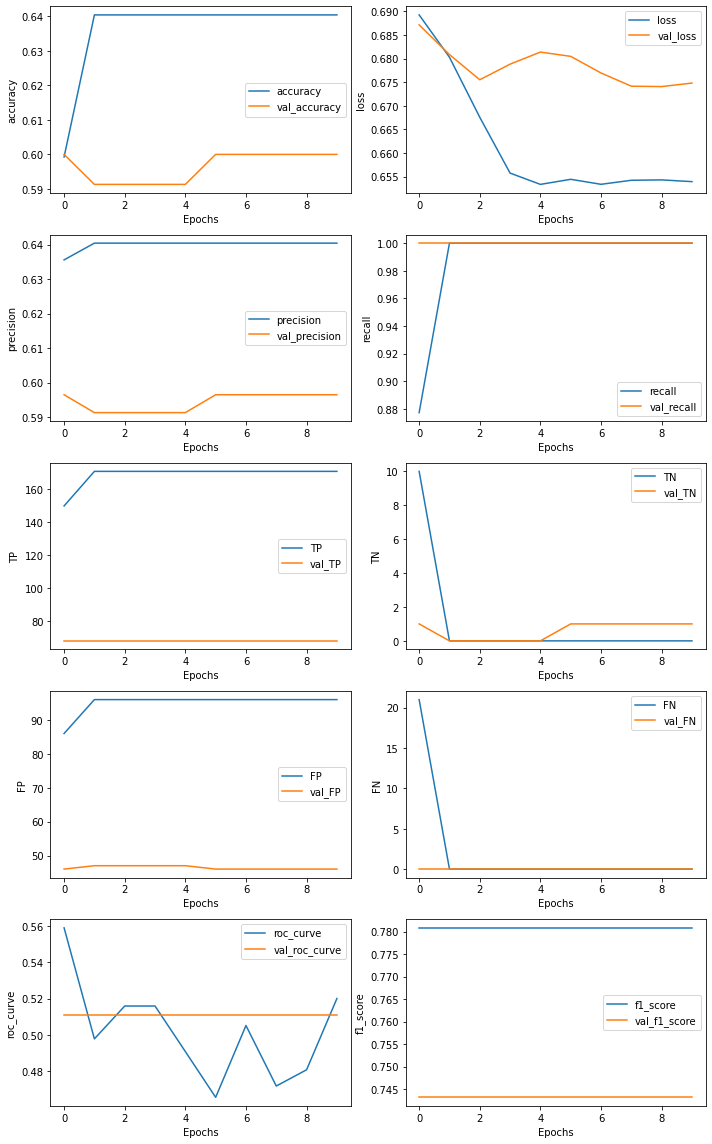

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)

fig.tight_layout()


4/4 - 0s - loss: 0.6748 - accuracy: 0.6000 - precision: 0.5965 - recall: 1.0000 - roc_curve: 0.5106 - FP: 46.0000 - FN: 0.0000e+00 - TP: 68.0000 - TN: 1.0000 - f1_score: 0.7432
Test loss: 0.6748175621032715
Test accuracy: 0.6000000238418579


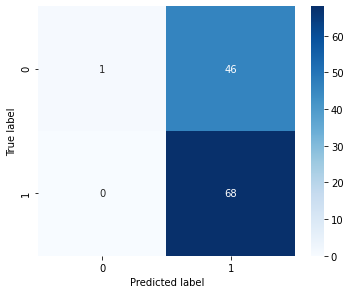

[[ 1 46]
 [ 0 68]]


In [0]:
y_pred = model.predict_classes(testing_padded)
confusion_matrix = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()

test_scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

figure = plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(confusion_matrix)

# Binary Classification (label : Preliminary decision)


### Sentiment Analysis using **Word Embedding** 



In [0]:
import json
import tensorflow as tf
import tensorflow_addons as tfa

import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# Define Hyper parameter
# it is important to define saparetely from your main code

vocab_size = 25000
embedding_dim = 16 # 16 dimentions
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3

In [0]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json

!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json


dataStore = []

with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)

--2020-05-04 21:08:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593600 (580K) [application/x-httpd-php]
Saving to: ‘/tmp/reviews.json’

/tmp/reviews.json   100%[===================>] 579.69K   860KB/s    in 0.7s    

2020-05-04 21:08:29 (860 KB/s) - ‘/tmp/reviews.json’ saved [593600/593600]



In [0]:
texts = []
labels = []

# remove where "Text" = "" & "Language" = "en" & remove stop words
for item in dataStore['paper']:
  # print(item['preliminary_decision'])
  item_label = item['preliminary_decision']
  item_reviews = item['review']
  label = -1
  text = ''

  if(item_label == 'accept' or item_label == 'no decision') : label = 1
  else : label = 0
  
  for item in item_reviews:
    text = item['text'];
    if(item['text']!="" and item['lan']!="en"):
      texts.append(text)
      labels.append(label)


print(len(texts)) 
# print(len(labels)) 

382


In [0]:
random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index


# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


training size :  267
testing size :  115


In [0]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'), # 6 nurons
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 nurons 
])
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 300, 16)           400000    
_________________________________________________________________
global_average_pooling1d_18  (None, 16)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 25        
Total params: 400,433
Trainable params: 400,433
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels), varbose = 2)

Epoch 1/10
9/9 [==============================] - 1s 139ms/step - loss: 0.6933 - accuracy: 0.4981 - precision: 0.6149 - recall: 0.6149 - roc_curve: 0.4290 - FP: 67.0000 - FN: 67.0000 - TP: 107.0000 - TN: 26.0000 - f1_score: 0.7891 - val_loss: 0.6904 - val_accuracy: 0.5913 - val_precision: 0.5913 - val_recall: 1.0000 - val_roc_curve: 0.4786 - val_FP: 47.0000 - val_FN: 0.0000e+00 - val_TP: 68.0000 - val_TN: 0.0000e+00 - val_f1_score: 0.7432
Epoch 2/10
9/9 [==============================] - 0s 11ms/step - loss: 0.6860 - accuracy: 0.6517 - precision: 0.6517 - recall: 1.0000 - roc_curve: 0.5014 - FP: 93.0000 - FN: 0.0000e+00 - TP: 174.0000 - TN: 0.0000e+00 - f1_score: 0.7891 - val_loss: 0.6872 - val_accuracy: 0.5913 - val_precision: 0.5913 - val_recall: 1.0000 - val_roc_curve: 0.4507 - val_FP: 47.0000 - val_FN: 0.0000e+00 - val_TP: 68.0000 - val_TN: 0.0000e+00 - val_f1_score: 0.7432
Epoch 3/10
9/9 [==============================] - 0s 11ms/step - loss: 0.6790 - accuracy: 0.6517 - precision:

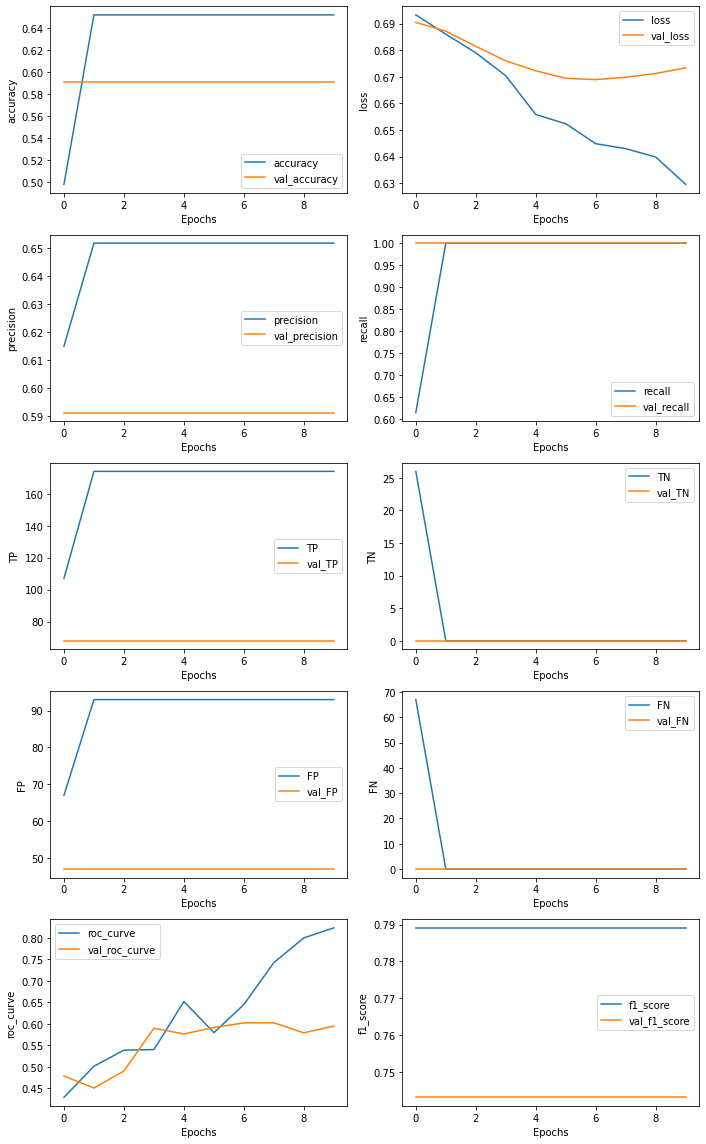

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)

fig.tight_layout()


### Using Previous model with removing **stopwords**


In [0]:
import json
import tensorflow as tf
import tensorflow_addons as tfa
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Hyper parameter
vocab_size = 25000
embedding_dim = 32 # 16 dimentions
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

texts = []
labels = []

for item in dataStore['paper']:
  item_label = item['preliminary_decision']
  item_reviews = item['review']
  label = -1
  text = ''

  if(item_label == 'accept' or item_label == 'no decision') : label = 1
  else : label = 0
  
  for item in item_reviews:
    text = item['text'];

    if(item['text']!="" and item['lan']!="en"):

      for word in stopwords:
        token = " " + word + " " ; 
        text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)

print(len(texts)) 


random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index


# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'), # 6 nurons
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 nurons 
])
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels), varbose = 2)

--2020-05-04 21:11:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593600 (580K) [application/x-httpd-php]
Saving to: ‘/tmp/reviews.json’

/tmp/reviews.json   100%[===================>] 579.69K   894KB/s    in 0.6s    

2020-05-04 21:11:30 (894 KB/s) - ‘/tmp/reviews.json’ saved [593600/593600]

382
training size :  267
testing size :  115
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 300, 32)           800000    
_________________________________________________________________
global_average_pooling1d_20  (None, 32)                0         
________________________________________________________

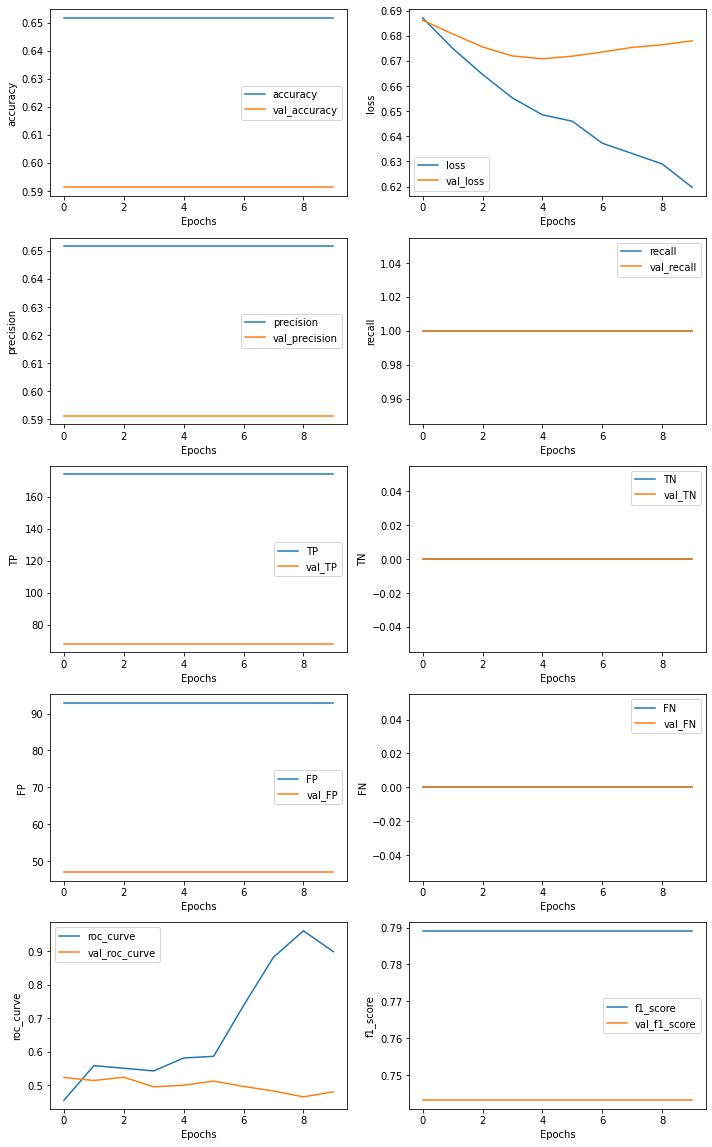

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)
fig.tight_layout()


### Analyze using Global Vector(**GloVe**) & **LSTM**

In [0]:
import json
import tensorflow as tf
import tensorflow_addons as tfa
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Hyper parameter
# vocab_size = 25000
embedding_dim = 100 # 16 dimentions
max_length = 1000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = .7  
test_portion = .3


!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json \
      -O /tmp/reviews.json

dataStore = []
with open("/tmp/reviews.json", 'r') as f:
    dataStore = json.load(f)


#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

texts = []
labels = []

for item in dataStore['paper']:
  item_label = item['preliminary_decision']
  item_reviews = item['review']
  label = -1
  text = ''

  if(item_label == 'accept' or item_label == 'no decision') : label = 1
  else : label = 0
  
  for item in item_reviews:
    text = item['text'];

    if(item['text']!="" and item['lan']!="en"):

      # for word in stopwords:
      #   token = " " + word + " " ; 
      #   text = text.replace(token, " ")

      texts.append(text)
      labels.append(label)

print(len(texts)) 

random.shuffle(texts)
training_size = int(float(.7 * len(texts))) 

# training & validation data set
training_texts = texts[0:training_size]
testing_texts = texts[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("training size : ", len(training_texts))
print("testing size : ", len(testing_texts))

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(word_index)

# training, testing sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

--2020-05-04 21:12:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593600 (580K) [application/x-httpd-php]
Saving to: ‘/tmp/reviews.json’

/tmp/reviews.json   100%[===================>] 579.69K   860KB/s    in 0.7s    

2020-05-04 21:12:39 (860 KB/s) - ‘/tmp/reviews.json’ saved [593600/593600]

382
training size :  267
testing size :  115
{'de': 1, 'la': 2, 'el': 3, 'en': 4, 'que': 5, 'se': 6, 'y': 7, 'no': 8, 'es': 9, 'a': 10, 'un': 11, 'los': 12, 'una': 13, 'del': 14, 'las': 15, 'para': 16, 'trabajo': 17, 'por': 18, 'artículo': 19, 'con': 20, 'como': 21, 'lo': 22, 'o': 23, 'al': 24, 'este': 25, 'más': 26, 'resultados': 27, 'ser': 28, 'presenta': 29, 'su': 30, '2': 31, 'son': 32, 'sin': 33, 'aplicación': 34, 'bien': 35, 'propuesta': 36, 'e

In [0]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-04 21:12:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   134MB/s    in 2.5s    

2020-05-04 21:12:50 (134 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics= ['accuracy',tf.keras.metrics.Precision(name='precision'), 
                        tf.keras.metrics.Recall(name = 'recall'), 
                        tf.keras.metrics.AUC(curve='ROC', name='roc_curve'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tfa.metrics.F1Score(num_classes= 1, name = 'f1_score')])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 1000, 100)         526900    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 996, 32)           16032     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 249, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 33        
Total params: 551,285
Trainable params: 24,385
Non-trainable params: 526,900
_________________________________________________________________
Epoch 1/10
9/9 - 3s - loss: 0.6857 - accuracy: 0.5955 - precision: 0.6398 - recall: 0.8678 - roc_curve: 0.52

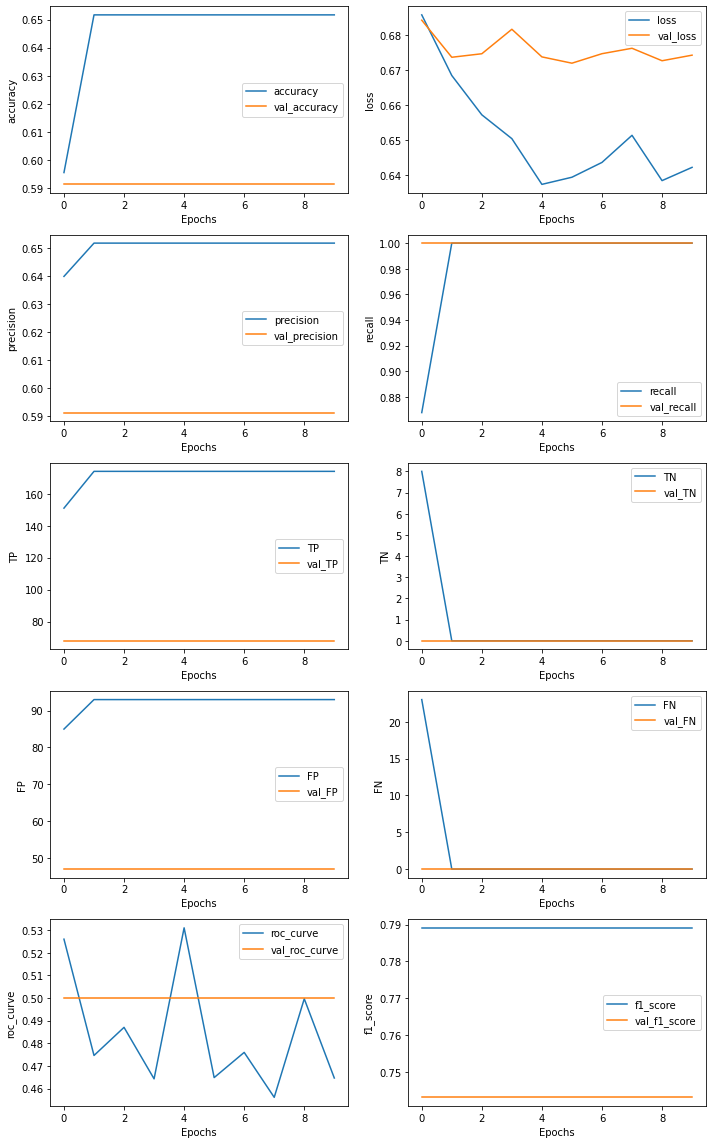

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,16))

def plot_graphs(history, string, x, y):
  axs[x, y].plot(history.history[string])
  axs[x, y].plot(history.history['val_'+string])
  axs[x, y].set(xlabel="Epochs", ylabel=string)
  axs[x, y].legend([string, 'val_'+string])

plot_graphs(history, 'accuracy', 0, 0)
plot_graphs(history, 'loss', 0, 1)
plot_graphs(history, 'precision', 1, 0)
plot_graphs(history, 'recall', 1, 1)
plot_graphs(history, 'TP', 2, 0)
plot_graphs(history, 'TN', 2, 1)
plot_graphs(history, 'FP', 3, 0)
plot_graphs(history, 'FN', 3, 1)
plot_graphs(history, 'roc_curve', 4, 0)
plot_graphs(history, 'f1_score', 4, 1)
fig.tight_layout()
